# <center>仅供学习的简单AI换脸技术</center>

By [青衣极客 Blue Geek]() In 2020-05-23

In [4]:
import os, sys
import numpy as np
# dlib官网文档：http://dlib.net/
import cv2, dlib
%matplotlib notebook
import matplotlib.pyplot as plt

## 1. 人脸检测

In [2]:
img1_path = '../data/bg106/image_0068.png'
img2_path = '../data/bg106/image_0147.png' 

In [9]:
face_detector = dlib.get_frontal_face_detector()
img1 = cv2.imread(img1_path, cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread(img2_path, cv2.IMREAD_COLOR)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
face1 = face_detector(img1, 1)
face2 = face_detector(img2, 1)
print(face1, face2)

rectangles[[(139, 139) (324, 325)]] rectangles[[(68, 142) (291, 365)]]


### 显示人脸检测结果

<IPython.core.display.Javascript object>


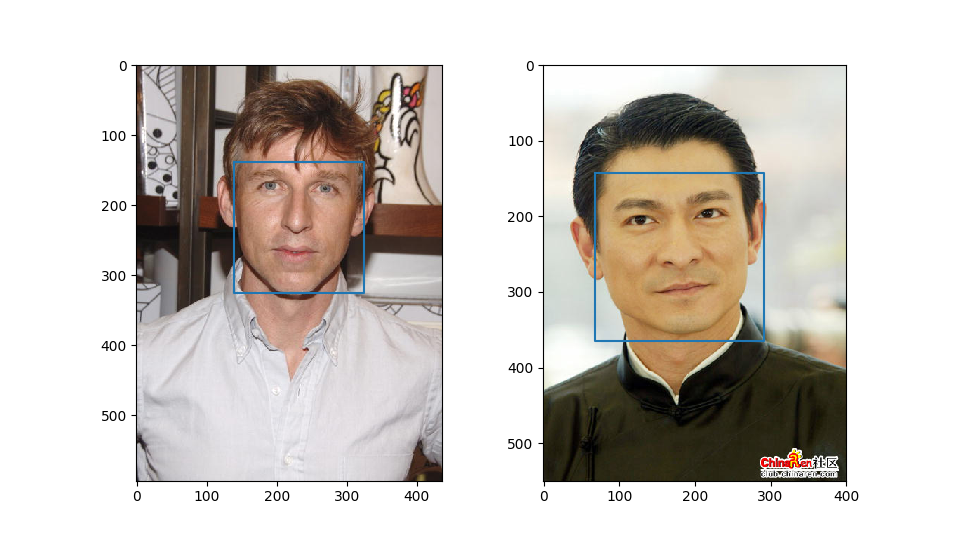

In [13]:
fig = plt.figure(figsize=(9.6, 5.4))
plt.subplot(1,2,1)
plt.imshow(img1)
rect = face1[0]
plt.plot([rect.left(), rect.right(), rect.right(), rect.left(), rect.left()], 
         [rect.top(), rect.top(), rect.bottom(), rect.bottom(), rect.top()])
plt.subplot(1,2,2)
plt.imshow(img2)
rect = face2[0]
plt.plot([rect.left(), rect.right(), rect.right(), rect.left(), rect.left()], 
         [rect.top(), rect.top(), rect.bottom(), rect.bottom(), rect.top()])

plt.savefig('../output/bg106/face_detect.png', bbox_inches='tight', dpi=150)

## 2. 关键点检测

In [16]:
LANDMARK_MODEL_PATH = os.path.expanduser('~/Database/Model/shape_predictor_68_face_landmarks.dat')
landmark_detector = dlib.shape_predictor(LANDMARK_MODEL_PATH)

In [30]:
pts1 = landmark_detector(img1, face1[0])
pts1 = np.array([[pt.x,pt.y] for pt in pts1.parts()])
pts2 = landmark_detector(img2, face2[0])
pts2 = np.array([[pt.x,pt.y] for pt in pts2.parts()])
print(pts1, pts2)

[[140 178]
 [142 204]
 [145 229]
 [147 253]
 [155 275]
 [169 294]
 [185 310]
 [203 325]
 [225 329]
 [246 326]
 [263 312]
 [279 297]
 [293 280]
 [302 259]
 [307 236]
 [312 212]
 [316 187]
 [158 163]
 [168 153]
 [184 148]
 [200 148]
 [215 154]
 [250 155]
 [266 150]
 [282 151]
 [297 158]
 [306 170]
 [232 174]
 [231 192]
 [230 208]
 [229 225]
 [212 233]
 [220 237]
 [228 241]
 [237 238]
 [245 235]
 [178 175]
 [187 169]
 [199 169]
 [208 177]
 [198 178]
 [187 179]
 [253 179]
 [263 172]
 [274 173]
 [283 179]
 [274 182]
 [263 181]
 [196 265]
 [206 260]
 [217 258]
 [227 262]
 [237 259]
 [248 263]
 [258 268]
 [248 278]
 [237 281]
 [226 282]
 [215 280]
 [205 275]
 [202 265]
 [216 266]
 [227 268]
 [237 267]
 [252 268]
 [237 270]
 [227 271]
 [216 268]] [[ 70 217]
 [ 74 242]
 [ 78 266]
 [ 85 290]
 [ 95 313]
 [114 330]
 [137 343]
 [164 354]
 [192 354]
 [217 348]
 [238 333]
 [255 315]
 [266 295]
 [270 271]
 [270 246]
 [269 222]
 [268 198]
 [ 92 193]
 [104 180]
 [122 176]
 [140 177]
 [158 183]
 [189 177

### 可视化关键点检测结果

<IPython.core.display.Javascript object>


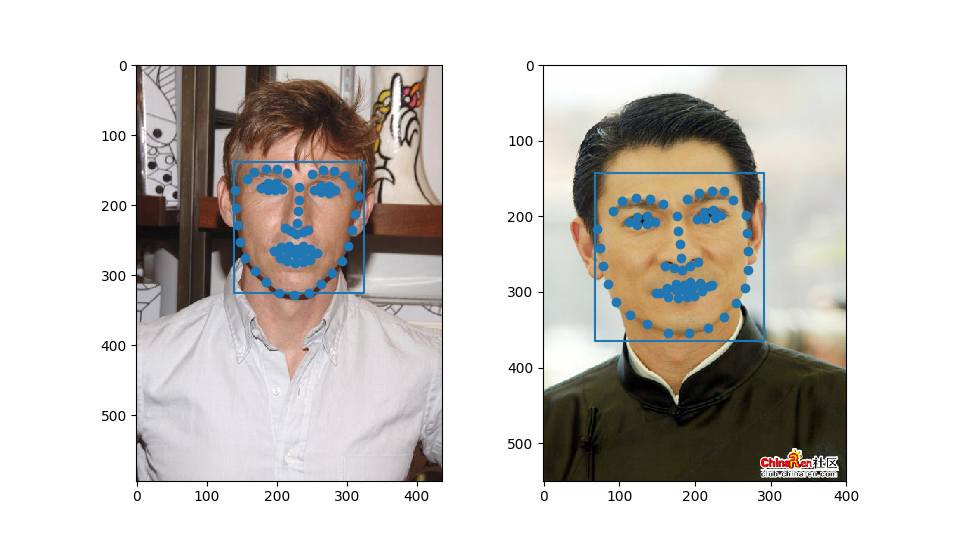

In [32]:
fig = plt.figure(figsize=(9.6, 5.4))
plt.subplot(1,2,1)
plt.imshow(img1)
rect = face1[0]
plt.plot([rect.left(), rect.right(), rect.right(), rect.left(), rect.left()], 
         [rect.top(), rect.top(), rect.bottom(), rect.bottom(), rect.top()])
plt.scatter(np.squeeze(pts1[:, 0]), np.squeeze(pts1[:, 1]), linewidths=1)
plt.subplot(1,2,2)
plt.imshow(img2)
rect = face2[0]
plt.plot([rect.left(), rect.right(), rect.right(), rect.left(), rect.left()], 
         [rect.top(), rect.top(), rect.bottom(), rect.bottom(), rect.top()])
plt.scatter(np.squeeze(pts2[:, 0]), np.squeeze(pts2[:, 1]), linewidths=1)
plt.savefig('../output/bg106/face_landmark.png', bbox_inches='tight', dpi=150)

## 3. 人脸图像变换

In [41]:
# 普氏分析：https://en.wikipedia.org/wiki/Procrustes_analysis#Ordinary_Procrustes_analysis
def compute_affine_param(pts1, pts2):
    pts1, pts2 = np.mat(pts1), np.mat(pts2)
    pts1, pts2 = pts1.astype(np.float64), pts2.astype(np.float64)
    # centrallize
    center1 = np.mean(pts1, axis=0)
    center2 = np.mean(pts2, axis=0)
    pts1 -= center1
    pts2 -= center2
    print()
    # normalize
    std1 = np.std(pts1)
    std2 = np.std(pts2)
    pts1 /= std1
    pts2 /= std2
    # compute rotation param by svd
    U, S, V = np.linalg.svd(pts1.transpose() * pts2)
    R = (U * V).transpose()
    # concat affine tranformation matrix
    tmp = (std2/std1)*R
    T = center2.transpose() - tmp*(center1.transpose())
#     print(T, tmp, T.shape, tmp.shape, center1.shape, center2.shape)
    affine = np.vstack([np.hstack([tmp, T]), np.matrix([0.0, 0.0, 1.0])])
    return affine
affine_params = compute_affine_param(pts1, pts2)
print(affine_params)


[[   1.07379748    0.16374229 -102.58234899]
 [  -0.16374229    1.07379748   46.87500841]
 [   0.            0.            1.        ]]


### 根据仿射变换warp图像

其实是相似变换，也算是特殊的仿射变换

In [42]:
w_img2 = np.zeros(img1.shape, dtype=img2.dtype)
cv2.warpAffine(img2, affine_params[:2], (w_img2.shape[1], w_img2.shape[0]), 
               dst=w_img2, flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_TRANSPARENT)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

### 显示图像warp的效果

<IPython.core.display.Javascript object>


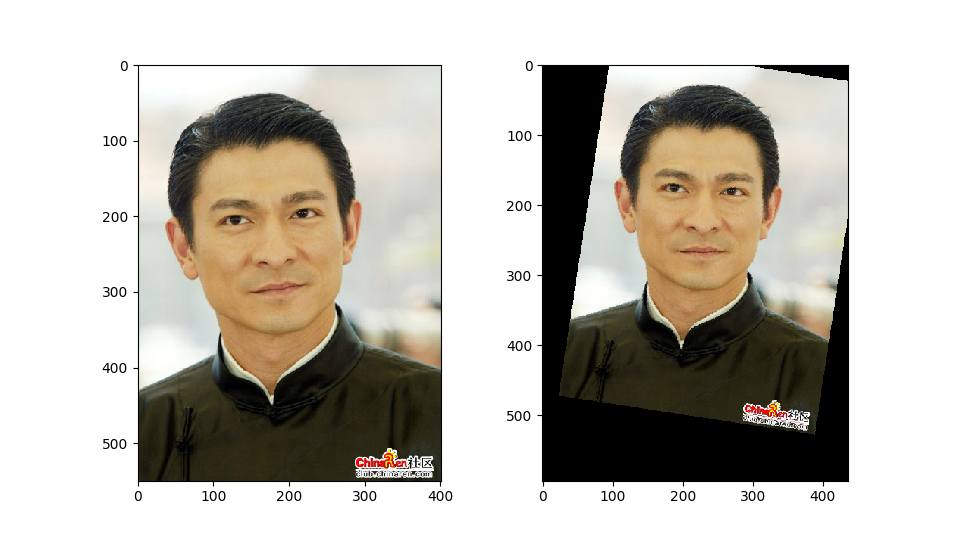

In [43]:
fig = plt.figure(figsize=(9.6, 5.4))
plt.subplot(1,2,1)
plt.imshow(img2)
plt.subplot(1,2,2)
plt.imshow(w_img2)
plt.savefig('../output/bg106/warp_img2.png', bbox_inches='tight', dpi=150)

## 4 图像融合

In [46]:
JAW_IDX = list(range(0, 17))
FACE_IDX = list(range(17, 68))
RIGHT_BROW_IDX = list(range(17, 22))
LEFT_BROW_IDX = list(range(22, 27))
NOSE_IDX = list(range(27, 35))
RIGHT_EYE_IDX = list(range(36, 42))
LEFT_EYE_IDX = list(range(42, 48))
MOUTH_IDX = list(range(48, 61))

COVER_IDX = [LEFT_BROW_IDX + RIGHT_EYE_IDX + LEFT_EYE_IDX 
             + RIGHT_BROW_IDX + NOSE_IDX + MOUTH_IDX]
def get_mask(img_shape, pts):
    img = np.zeros(img_shape[:2], dtype=np.float64)
    for idx in COVER_IDX:
        cv2.fillConvexPoly(img, cv2.convexHull(pts[idx]), color=1)
    img = np.array([img, img, img]).transpose([1,2,0])
    img = (cv2.GaussianBlur(img, (13, 13), 0) > 0) * 1.0
    img = cv2.GaussianBlur(img, (13, 13), 0)
    return img

mask1 = get_mask(img1.shape, pts1)
mask2 = get_mask(img2.shape, pts2)
print(mask1, mask2)

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]] [[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  .

### 可视化两幅图像的遮罩

<IPython.core.display.Javascript object>


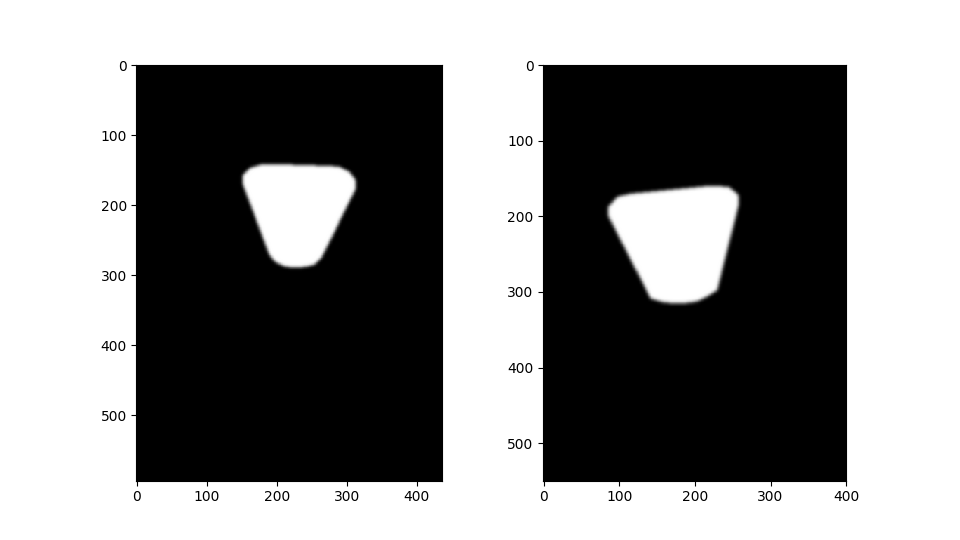

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [47]:
fig = plt.figure(figsize=(9.6, 5.4))
plt.subplot(1,2,1)
plt.imshow(mask1)
plt.subplot(1,2,2)
plt.imshow(mask2)
plt.savefig('../output/bg106/mask.png', bbox_inches='tight', dpi=150)

### 可视化两幅图像中对应的部分

<IPython.core.display.Javascript object>


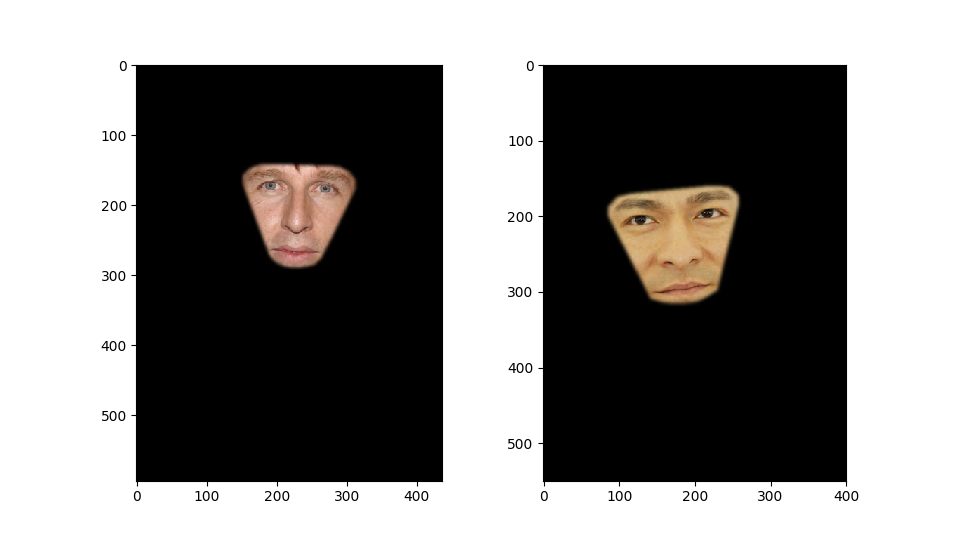

In [73]:
fig = plt.figure(figsize=(9.6, 5.4))
plt.subplot(1,2,1)
plt.imshow((mask1*img1).astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow((mask2*img2).astype(np.uint8))
plt.savefig('../output/bg106/mask_img.png', bbox_inches='tight', dpi=150)

### 生成一个统一的遮罩

也就是最终真正使用的遮罩

In [48]:
w_mask2 = np.zeros(img1.shape, dtype=img2.dtype)
cv2.warpAffine(mask2, affine_params[:2], (w_img2.shape[1], w_img2.shape[0]), 
               dst=w_img2, flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_TRANSPARENT)
mix_mask = np.max([mask1, w_mask2], axis=0)

### 显示统一遮罩

<IPython.core.display.Javascript object>


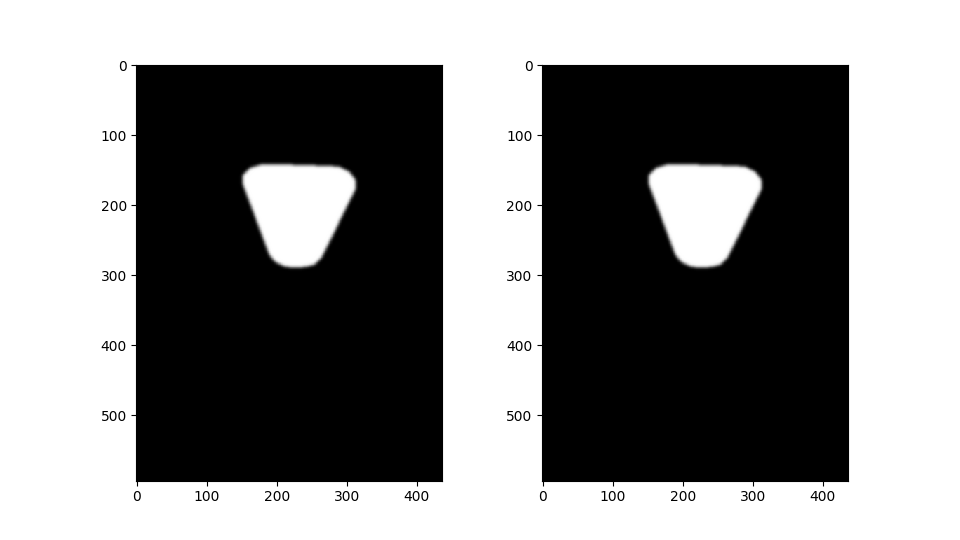

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [49]:
fig = plt.figure(figsize=(9.6, 5.4))
plt.subplot(1,2,1)
plt.imshow(mask1)
plt.subplot(1,2,2)
plt.imshow(mix_mask)
plt.savefig('../output/bg106/mix_mask.png', bbox_inches='tight', dpi=150)

### 显示统一遮罩的作用区域

<IPython.core.display.Javascript object>


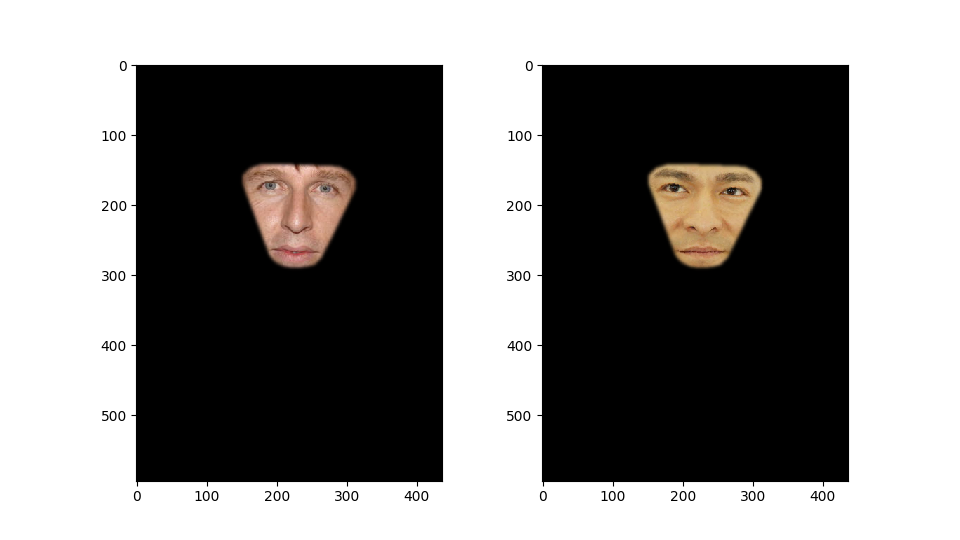

In [75]:
fig = plt.figure(figsize=(9.6, 5.4))
plt.subplot(1,2,1)
plt.imshow((mix_mask*img1).astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow((mix_mask*w_img2).astype(np.uint8))
plt.savefig('../output/bg106/mix_mask_img.png', bbox_inches='tight', dpi=150)

### 直接替换的效果

<IPython.core.display.Javascript object>


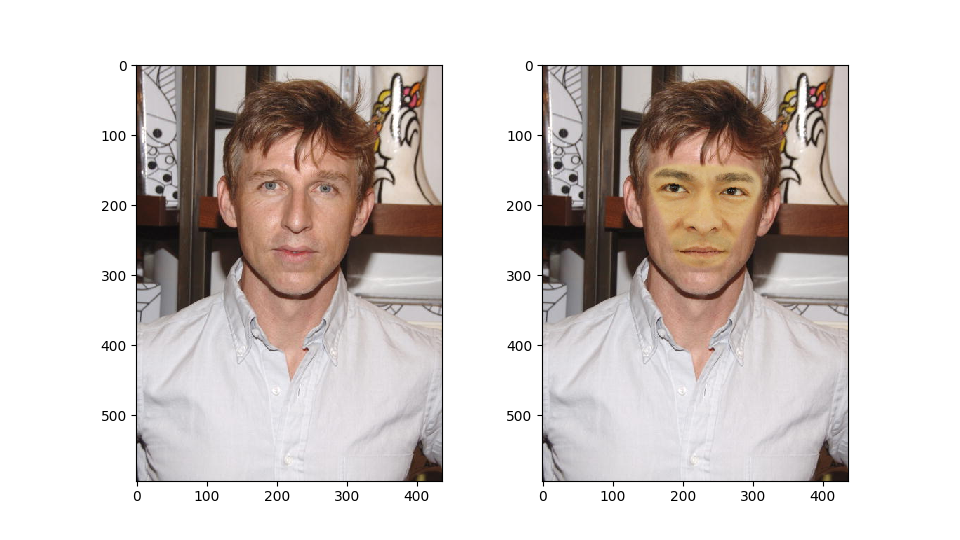

In [76]:
rough_dst_img = img1 * (1.0 - mix_mask) + w_img2 * mix_mask
fig = plt.figure(figsize=(9.6, 5.4))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(rough_dst_img.astype(np.uint8))
plt.savefig('../output/bg106/rough_dst_img.png', bbox_inches='tight', dpi=150)

## 5. 颜色矫正

In [69]:
# 颜色平衡方法：https://en.wikipedia.org/wiki/Color_balance#Scaling_monitor_R.2C_G.2C_and_B
def adjust_color(img1, img2, pts, blur_factor=0.5):
    mean_le = np.mean(pts[LEFT_EYE_IDX], axis=0)
    mean_re = np.mean(pts[RIGHT_EYE_IDX], axis=0)
    blur_degree = int(blur_factor * np.linalg.norm(mean_le - mean_re))
    print(blur_degree)
    if blur_degree % 2 == 0:
        blur_degree += 1
    blur_img1 = cv2.GaussianBlur(img1, (blur_degree, blur_degree), 0)
    blur_img2 = cv2.GaussianBlur(img2, (blur_degree, blur_degree), 0)
    blur_img1 = blur_img1.astype(np.float64)
    blur_img2 = blur_img2.astype(np.float64)
    blur_img2 += (blur_img2 <= 1.0) * 128
    img2 = img2.astype(np.float64)
    return img2 * blur_img1 / blur_img2

adjust_img = adjust_color(img1, w_img2, pts1, blur_factor=0.8)

60


### 颜色矫正的效果

<IPython.core.display.Javascript object>


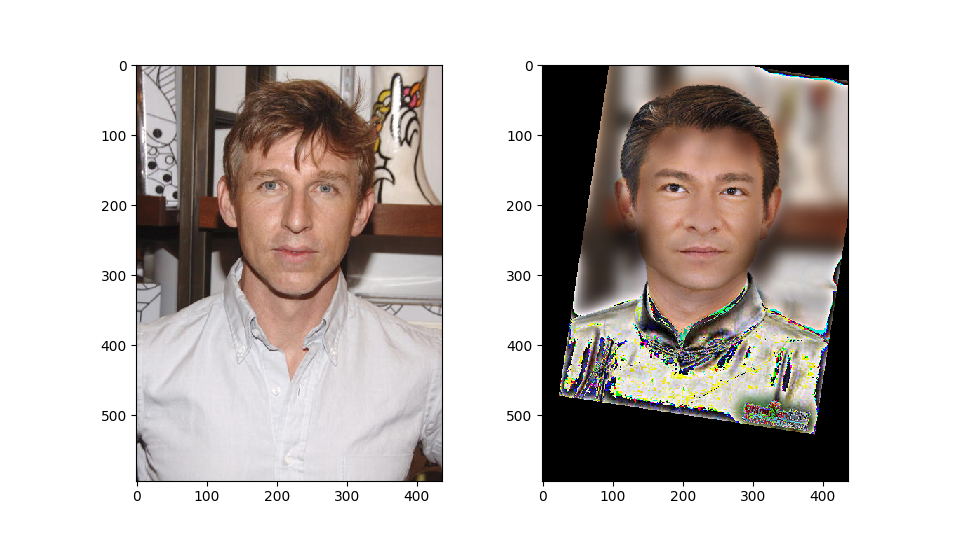

In [70]:
fig = plt.figure(figsize=(9.6, 5.4))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(adjust_img.astype(np.uint8))
plt.savefig('../output/bg106/adjust_img.png', bbox_inches='tight', dpi=150)

### 颜色矫正后再用遮罩替换的效果

也就是最终效果

<IPython.core.display.Javascript object>


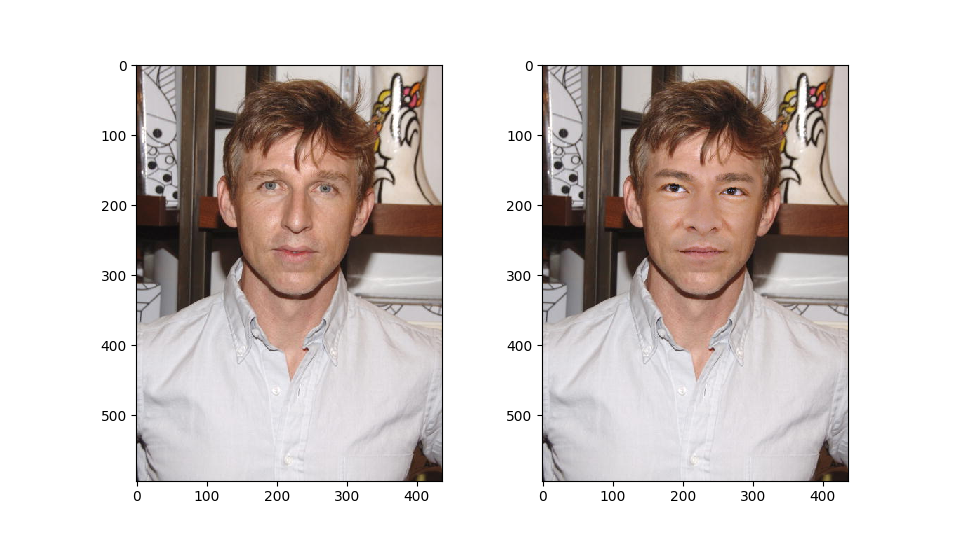

In [71]:
dst_img = img1 * (1.0 - mix_mask) + adjust_img * mix_mask
fig = plt.figure(figsize=(9.6, 5.4))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.subplot(1,2,2)
plt.imshow(dst_img.astype(np.uint8))
plt.savefig('../output/bg106/dst_img.png', bbox_inches='tight', dpi=150)